<a href="https://colab.research.google.com/github/VineetMakharia/NN-ipynbs/blob/main/Copy_of_Terrain_Identification_vrmakhar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
import sys

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

!fusermount -u drive
!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/gdrive/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found


In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/")
!ls

'My Drive'


In [ ]:
dir_path = '/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/'
dir_path_test = '/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TestData/'
sub_001 = 'subject_001_01__x.csv'
sub_001_time = 'subject_001_01__x_time.csv'
sub_001_y = 'subject_001_01__y.csv'
sub_001_time_y = 'subject_001_01__y_time.csv'

# testing data files
sub_009_01_x = 'subject_009_01__x.csv'
sub_009_01_x_time = 'subject_009_01__x_time.csv'
sub_009_01_y_time = 'subject_009_01__y_time.csv'

sys.path.append(dir_path)
sys.path.append(dir_path_test)
# /content/gdrive/My Drive/ECE542_fa20_Project_TerrainRecognition/TestData/subject_009_01__x.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

"_x" files contain the xyz accelerometers and xyz gyroscope measurements from the lower limb.

In [ ]:
columns_x = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro']

sub_001_data = pd.read_csv('/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/subject_001_01__x.csv', names=columns_x)
sub_001_data.head()

sub_001_data.shape

(37890, 6)

"_x_time" files contain the time stamps for the accelerometer and gyroscope measurements. The units are in seconds and the sampling rate is 40 Hz. 

In [ ]:
columns_x_time = ['x_time']

sub_001_time_data = pd.read_csv('/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/subject_001_01__x_time.csv', names=columns_x_time)
sub_001_time_data.head()

sub_001_time_data.shape

(37890, 1)

"_y" files contain the labels. 
(0) indicates standing or walking in solid ground, 
(1) indicates going down the stairs, 
(2) indicates going up the stairs, and 
(3) indicates walking on grass.

In [ ]:
columns_y = ['labels']

sub_001_y_data = pd.read_csv('/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/subject_001_01__y.csv', names=columns_y)
sub_001_y_data.head()

sub_001_y_data.shape

(9473, 1)

"_y_time" files contain the time stampes for the labels. The units are in seconds and the sampling rates is 10 Hz. 

In [ ]:
columns_y_time = ['y_time']

sub_001_time_y_data = pd.read_csv('/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/subject_001_01__y_time.csv', names=columns_y_time)
sub_001_time_y_data.head()

sub_001_time_y_data.shape

(9473, 1)

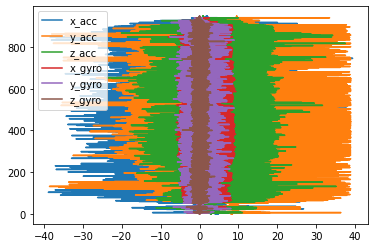

In [ ]:
plt.plot(sub_001_data,sub_001_time_data)
plt.legend(columns_x)
plt.show()

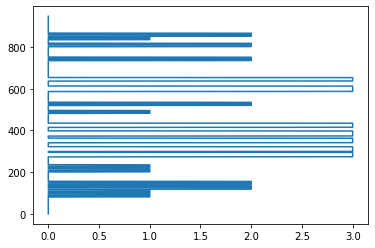

In [ ]:
plt.plot(sub_001_y_data,sub_001_time_y_data)
plt.show()

In [ ]:
sub_001_y_data['labels'].value_counts()

0    6444
3    1530
2     788
1     711
Name: labels, dtype: int64

https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

Test data - 009_01

In [ ]:
def transform_to_supervised(df,
                            previous_steps=1, 
                            forecast_steps=1,
                            dropnan=True):

    """
    Transforms a DataFrame containing time series data into a DataFrame
    containing data suitable for use as a supervised learning problem.
    
    Derived from code originally found at 
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    
    :param df: pandas DataFrame object containing columns of time series values
    :param previous_steps: the number of previous steps that will be included in the
                           output DataFrame corresponding to each input column
    :param forecast_steps: the number of forecast steps that will be included in the
                           output DataFrame corresponding to each input column
    :return Pandas DataFrame containing original columns, renamed <orig_name>(t), as well as
            columns for previous steps, <orig_name>(t-1) ... <orig_name>(t-n) and columns 
            for forecast steps, <orig_name>(t+1) ... <orig_name>(t+n)
    """
    
    # original column names
    col_names = df.columns
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(previous_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecast_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % col_name) for col_name in col_names]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [ ]:
def read_and_merge_data(file_name):
  x_data = pd.read_csv(dir_path + 'subject_' + file_name + '__x.csv', names=columns_x)
  x_time_data = pd.read_csv(dir_path + 'subject_' + file_name + '__x_time.csv', names=columns_x_time)
  y_data = pd.read_csv(dir_path + 'subject_' + file_name + '__y.csv', names=columns_y)

  # rounding of time 
  x_data['time'] = np.floor(x_time_data.apply(lambda x: x * 10))
  # merging four rows using mean
  x_data_grouped = x_data.groupby('time').mean()
  # adding y label to data
  x_data_grouped['label'] = y_data

  return x_data_grouped

In [ ]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [ ]:
sub_001_files = ['001_01', '001_02', '001_03', '001_04', '001_05', '001_06', '001_07']
sub_001_data = pd.DataFrame()

for file in sub_001_files:
  dataset = read_and_merge_data(file)
  sub_001_data = pd.concat([sub_001_data, dataset], axis=0)

In [ ]:
print(sub_001_data.shape)
sub_001_data.head()

(83837, 7)


,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,label
time,,,,,,,
0.0,4.504035,8.340198,2.918309,0.013933,-0.007974,-0.008288,0.0
1.0,4.425359,8.271379,2.844811,0.016234,-0.011429,-0.014507,0.0
2.0,4.300705,8.236062,2.834814,-0.001040,-0.008740,0.005591,0.0
3.0,4.366163,8.318765,2.861348,-0.004983,0.014596,0.042397,0.0
4.0,4.696528,8.227105,2.842579,-0.008219,0.024097,0.021717,0.0


In [ ]:
prev, col_labels = 5, []

transformed_data_train = transform_to_supervised(sub_001_data, previous_steps=prev)

for i in range(prev, 0, -1):
  col_labels.append('label(t-' + str(i) + ')')

col_labels.append('label(t)')
transformed_data_train = transformed_data_train[[c for c in transformed_data_train.columns if c not in col_labels] + col_labels]

transformed_data_train_x = transformed_data_train.drop('label(t)', axis=1)
transformed_data_train_y = transformed_data_train['label(t)']

In [ ]:
transformed_data_train_x.columns

Index(['x_acc(t-5)', 'y_acc(t-5)', 'z_acc(t-5)', 'x_gyro(t-5)', 'y_gyro(t-5)',
       'z_gyro(t-5)', 'x_acc(t-4)', 'y_acc(t-4)', 'z_acc(t-4)', 'x_gyro(t-4)',
       'y_gyro(t-4)', 'z_gyro(t-4)', 'x_acc(t-3)', 'y_acc(t-3)', 'z_acc(t-3)',
       'x_gyro(t-3)', 'y_gyro(t-3)', 'z_gyro(t-3)', 'x_acc(t-2)', 'y_acc(t-2)',
       'z_acc(t-2)', 'x_gyro(t-2)', 'y_gyro(t-2)', 'z_gyro(t-2)', 'x_acc(t-1)',
       'y_acc(t-1)', 'z_acc(t-1)', 'x_gyro(t-1)', 'y_gyro(t-1)', 'z_gyro(t-1)',
       'x_acc(t)', 'y_acc(t)', 'z_acc(t)', 'x_gyro(t)', 'y_gyro(t)',
       'z_gyro(t)', 'label(t-5)', 'label(t-4)', 'label(t-3)', 'label(t-2)',
       'label(t-1)'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
transformed_data_train_x = scaler.fit_transform(transformed_data_train_x)

In [ ]:
# calculate the performance metrics of the model
def evaluate_performance(model_name, y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  conf = confusion_matrix(y_test, y_pred)

  print("{}: \nAccuracy:{:.4f}".format(model_name, accuracy))
  print("Precision:{:.4f} \tRecall:{:.4f} \tF1-Score:{:.4f}".format(precision, recall, f1))
  print("Confusion Matrix: \n{}".format(conf))

# scale the input values to models with standard scalar
def scale_input_data(X_train, X_test):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.fit_transform(X_test)

  return X_train_scaled, X_test_scaled

In [ ]:
def classify_SVM(X_train, X_test, y_train, y_test):
  # scaling the data
  X_train_scaled, X_test_scaled = scale_input_data(X_train, X_test)

  # Multiclass SVM with rbf kernel
  svm_classifier = LinearSVC(C = 15, multi_class = 'ovr', random_state = 30, 
                             max_iter=400000)
  svm_classifier.fit(X_train_scaled, y_train)

  # predicting test data
  y_pred = svm_classifier.predict(X_test_scaled)
  evaluate_performance('SVM classifier', y_test, y_pred)

In [ ]:
cp = sub_001_data.dropna()

In [ ]:
tx, vx, ty, vy = train_test_split(cp[cp.columns.difference(['label'])], 
                                  cp['label'], random_state=17)

In [ ]:
print(cp.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 83836 entries, 0.0 to 7855.0
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_acc   83836 non-null  float64
 1   y_acc   83836 non-null  float64
 2   z_acc   83836 non-null  float64
 3   x_gyro  83836 non-null  float64
 4   y_gyro  83836 non-null  float64
 5   z_gyro  83836 non-null  float64
 6   label   83836 non-null  float64
dtypes: float64(7)
memory usage: 5.1 MB
None


In [ ]:
classify_SVM(tx, vx, ty, vy)

SVM classifier: 
Accuracy:0.7499
Precision:0.4218 	Recall:0.2522 	F1-Score:0.2187
Confusion Matrix: 
[[15703     0     0     0]
 [ 1357     0     0     0]
 [ 1668     0    15     0]
 [ 2215     0     1     0]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def classify_RF(X_train, X_test, y_train, y_test):
  # scaling the data
  X_train_scaled, X_test_scaled = scale_input_data(X_train, X_test)

  clf=RandomForestClassifier(n_estimators=200, bootstrap=False)
  clf.fit(X_train_scaled,y_train)

  y_pred=clf.predict(X_test)

  y_pred = clf.predict(X_test_scaled)
  evaluate_performance('RF', y_test, y_pred)

In [ ]:
tx, vx, ty, vy = train_test_split(cp[cp.columns.difference(['label'])], 
                                  cp['label'], random_state=17)

In [ ]:
classify_RF(tx, vx, ty, vy)

RF: 
Accuracy:0.8463
Precision:0.7911 	Recall:0.6294 	F1-Score:0.6692
Confusion Matrix: 
[[15247   148   125   183]
 [  520   801    19    17]
 [  303    20  1355     5]
 [ 1832    40     9   335]]


In [ ]:
from sklearn import tree

In [ ]:
def classify_tree(X_train, X_test, y_train, y_test):
  # scaling the data
  X_train_scaled, X_test_scaled = scale_input_data(X_train, X_test)

  clf=clf = tree.DecisionTreeClassifier()
  clf.fit(X_train_scaled,y_train)

  y_pred=clf.predict(X_test)

  y_pred = clf.predict(X_test_scaled)
  evaluate_performance('RF', y_test, y_pred)

In [ ]:
tx, vx, ty, vy = train_test_split(cp[cp.columns.difference(['label'])], 
                                  cp['label'], random_state=17)

In [ ]:
classify_tree(tx, vx, ty, vy)

RF: 
Accuracy:0.7613
Precision:0.5980 	Recall:0.5984 	F1-Score:0.5982
Confusion Matrix: 
[[13396   455   354  1498]
 [  449   741    60   107]
 [  366    62  1215    40]
 [ 1460   102    50   604]]
